<a href="https://colab.research.google.com/github/hassane-37/DeepLaser/blob/tache3/deeplaser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#
import os
import random
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gen import generate_data

from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import grad

# Reproductibilité
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Device (GPU/CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f" Using device: {device}")


In [ ]:
#Génération de données haute résolution (~10 000 points)
from datetime import datetime
def log(msg): print(f"[{datetime.now().strftime('%H:%M:%S')}] {msg}")

params = dict(
    tau=1e-11,           # s
    fluence=300.0,       # J/m^2
    wavelength=400e-9,   # m
    t_end=60e-12,        # durée totale simulée
    steps_per_tau=1600   # densité très élevée (~10k points)
)

log("Generating high-density data (~10k points)...")
time, Te, Tl, Tw, sigma_abs = generate_data(**params)

import pandas as pd, matplotlib.pyplot as plt, numpy as np
data = pd.DataFrame({"time_s": time, "T_e_K": Te, "T_l_K": Tl, "T_w_K": Tw})

# Infos pratiques
dt = float(time[1]-time[0]) if len(time) > 1 else float('nan')
log(f"points = {len(time):,} | dt = {dt:.3e} s | t_end = {params['t_end']:.3e} s")
log(f"sigma_abs = {sigma_abs:.3e} m^2")
display(data.head())

[14:36:47] Generating high-density data (~10k points)...
[14:36:47] points = 9,600 | dt = 6.250e-15 s | t_end = 6.000e-11 s
[14:36:47] sigma_abs = 7.786e-18 m^2


,time_s,T_e_K,T_l_K,T_w_K
0,0.000000e+00,300.000000,300.000000,300.0
1,6.250000e-15,302.728601,300.000000,300.0
2,1.250000e-14,305.385660,300.000379,300.0
3,1.875000e-14,307.974559,300.001127,300.0
4,2.500000e-14,310.498448,300.002234,300.0


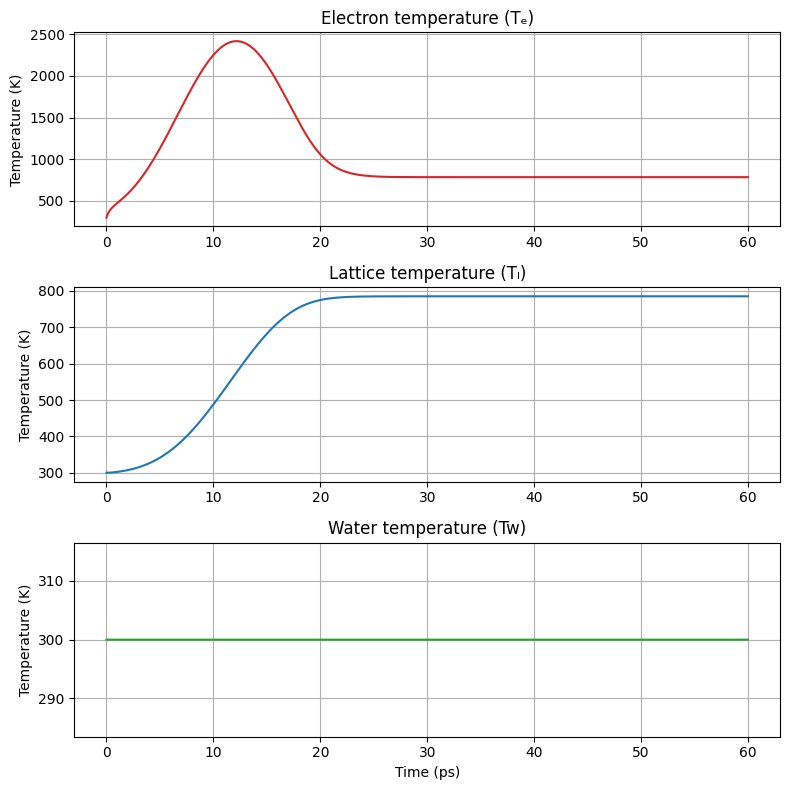

[14:37:13] Dense data plotted (3 separate graphs).


In [ ]:
#Plot de contrôle (3 sous-graphiques séparés)
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))

# --- Electron temperature ---
plt.subplot(3, 1, 1)
plt.plot(data["time_s"]/1e-12, data["T_e_K"], color="tab:red")
plt.title("Electron temperature (Tₑ)")
plt.ylabel("Temperature (K)")
plt.grid(True)

# --- Lattice temperature ---
plt.subplot(3, 1, 2)
plt.plot(data["time_s"]/1e-12, data["T_l_K"], color="tab:blue")
plt.title("Lattice temperature (Tₗ)")
plt.ylabel("Temperature (K)")
plt.grid(True)

# --- Water temperature ---
plt.subplot(3, 1, 3)
plt.plot(data["time_s"]/1e-12, data["T_w_K"], color="tab:green")
plt.title("Water temperature (Tw)")
plt.xlabel("Time (ps)")
plt.ylabel("Temperature (K)")
plt.grid(True)

plt.tight_layout()
plt.show()
log("Dense data plotted (3 separate graphs).")


# Tache 1 : Ajustement de courbes

Tâche 1 - Ajustement de courbes (modèle classique)

In [ ]:
#Split chronologique (70/15/15)
def log(msg):
    from datetime import datetime
    print(f"[{datetime.now().strftime('%H:%M:%S')}] {msg}")

X = data[["time_s"]].values.astype(np.float32)
y = data[["T_e_K", "T_l_K", "T_w_K"]].values.astype(np.float32)

N = len(X)
n_train = int(0.70 * N)
n_val   = int(0.15 * N)

X_train, y_train = X[:n_train], y[:n_train]
X_val,   y_val   = X[n_train:n_train+n_val], y[n_train:n_train+n_val]
X_test,  y_test  = X[n_train+n_val:], y[n_train+n_val:]

log(f"Split done → train:{len(X_train)} | val:{len(X_val)} | test:{len(X_test)} | total:{N}")


[14:36:47] Split done → train:6720 | val:1440 | test:1440 | total:9600


In [ ]:
# Normalisation des données
from sklearn.preprocessing import StandardScaler
import numpy as np

# normalise t ∈ [0,1] selon train
t_max = float(X_train.max())
X_train_s = X_train / t_max
X_val_s   = X_val   / t_max
X_test_s  = X_test  / t_max

# standardise les 3 sorties (fit sur train seulement)
y_scaler = StandardScaler().fit(y_train)
y_train_s = y_scaler.transform(y_train)
y_val_s   = y_scaler.transform(y_val)
y_test_s  = y_scaler.transform(y_test)

log(f"t_max = {t_max:.3e} s")
log(f"y mean = {y_scaler.mean_}")
log(f"y scale = {y_scaler.scale_}")


[14:36:47] t_max = 4.199e-11 s
[14:36:47] y mean = [1174.66846144  654.6874082   300.        ]
[14:36:47] y scale = [591.17087913 179.39155647   1.        ]


In [ ]:
# === Datasets et DataLoaders ===
class TimeTempDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float()
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.y[i]

train_ds = TimeTempDataset(X_train_s, y_train_s)
val_ds   = TimeTempDataset(X_val_s,   y_val_s)
test_ds  = TimeTempDataset(X_test_s,  y_test_s)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=256, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=256, shuffle=False)

log(f"DataLoaders ready → train:{len(train_loader)} batches | val:{len(val_loader)} | test:{len(test_loader)}")


[14:36:47] DataLoaders ready → train:105 batches | val:6 | test:6


In [ ]:
# Modèle MLP
class MLP(nn.Module):
    def __init__(self, in_dim=1, hidden=(64,64), out_dim=3):
        super().__init__()
        layers = []
        last = in_dim
        for h in hidden:
            layers += [nn.Linear(last, h), nn.ReLU()]
            last = h
        layers += [nn.Linear(last, out_dim)]
        self.net = nn.Sequential(*layers)
    def forward(self, x): return self.net(x)

model = MLP().to(device)
params_count = sum(p.numel() for p in model.parameters() if p.requires_grad)
log(f"MLP initialisé → {params_count} paramètres entraînables sur {device}")


[14:36:47] MLP initialisé → 4483 paramètres entraînables sur cpu


In [ ]:
# Entraînement
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
EPOCHS, PATIENCE = 400, 30

best_val = np.inf
wait = 0
best_state = None
history = {"train": [], "val": []}

for epoch in range(1, EPOCHS + 1):
    # phase train
    model.train()
    train_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * len(xb)
    train_loss /= len(train_loader.dataset)

    # phase val
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            loss = criterion(pred, yb)
            val_loss += loss.item() * len(xb)
    val_loss /= len(val_loader.dataset)

    history["train"].append(train_loss)
    history["val"].append(val_loss)

    improved = val_loss < best_val - 1e-8
    if improved:
        best_val = val_loss
        best_state = {k: v.detach().cpu().clone() for k,v in model.state_dict().items()}
        wait = 0
    else:
        wait += 1

    if epoch % 20 == 0 or epoch == 1 or improved:
        log(f"Epoch {epoch:03d} | Train={train_loss:.6f} | Val={val_loss:.6f} | Best={best_val:.6f} | Wait={wait}")
    if wait >= PATIENCE:
        log(f"Early stopping at epoch {epoch}")
        break

model.load_state_dict(best_state)
log("Best model restored.")


[14:36:47] Epoch 001 | Train=0.430134 | Val=0.160323 | Best=0.160323 | Wait=0
[14:36:47] Epoch 002 | Train=0.218964 | Val=0.081735 | Best=0.081735 | Wait=0
[14:36:48] Epoch 004 | Train=0.037664 | Val=0.005894 | Best=0.005894 | Wait=0
[14:36:48] Epoch 005 | Train=0.009568 | Val=0.000817 | Best=0.000817 | Wait=0
[14:36:48] Epoch 006 | Train=0.003283 | Val=0.000705 | Best=0.000705 | Wait=0
[14:36:48] Epoch 007 | Train=0.001648 | Val=0.000317 | Best=0.000317 | Wait=0
[14:36:51] Epoch 020 | Train=0.000241 | Val=0.000753 | Best=0.000317 | Wait=13
[14:36:54] Early stopping at epoch 37
[14:36:54] Best model restored.


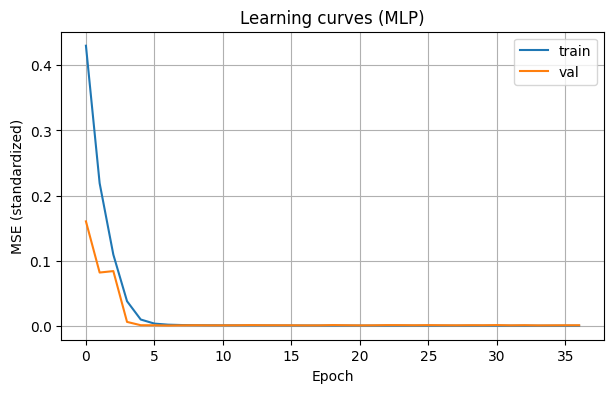

[14:36:54] Courbes d’apprentissage affichées.


In [ ]:
plt.figure(figsize=(7,4))
plt.plot(history["train"], label="train")
plt.plot(history["val"], label="val")
plt.xlabel("Epoch"); plt.ylabel("MSE (standardized)")
plt.title("Learning curves (MLP)")
plt.legend(); plt.grid(True)
plt.show()
log("Courbes d’apprentissage affichées.")


In [ ]:
model.eval()
preds_s, trues_s = [], []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        preds_s.append(model(xb).cpu().numpy())
        trues_s.append(yb.numpy())

preds_s = np.vstack(preds_s)
trues_s = np.vstack(trues_s)

# inverse scaling
preds = y_scaler.inverse_transform(preds_s)
trues = y_scaler.inverse_transform(trues_s)

def rmse(a,b): return float(np.sqrt(mean_squared_error(a,b)))
for i, name in enumerate(["T_e_K","T_l_K","T_w_K"]):
    mae = mean_absolute_error(trues[:,i], preds[:,i])
    r   = rmse(trues[:,i], preds[:,i])
    log(f"{name:6s} | MAE={mae:.4f} K | RMSE={r:.4f} K")


[14:36:54] T_e_K  | MAE=38.6694 K | RMSE=40.1377 K
[14:36:54] T_l_K  | MAE=4.4005 K | RMSE=4.4050 K
[14:36:54] T_w_K  | MAE=0.0130 K | RMSE=0.0134 K


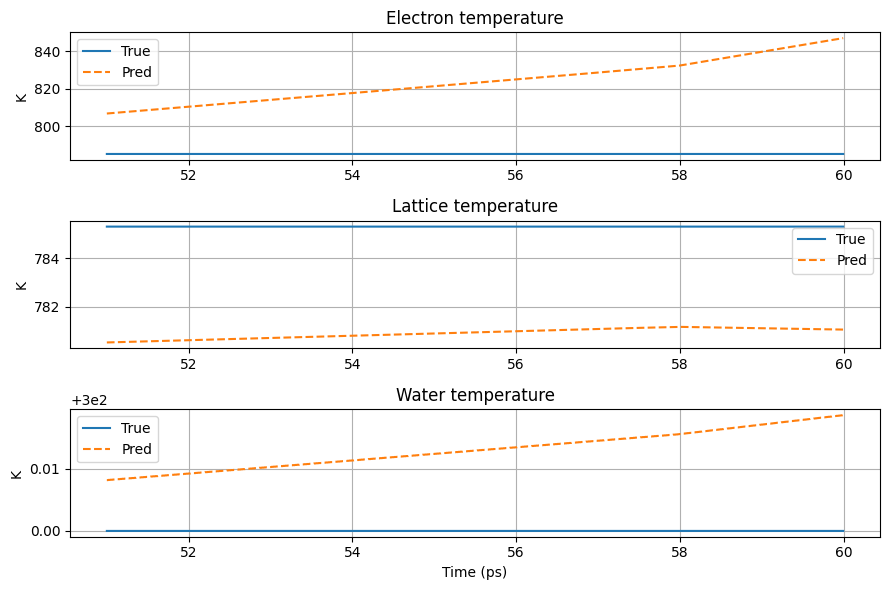

,time_ps,true_K,pred_K,abs_err_K
0,53,785.316,814.082,28.766
1,54,785.316,817.712,32.396
2,55,785.316,821.342,36.026
3,56,785.316,824.972,39.656
4,57,785.316,828.601,43.286
5,58,785.316,832.350,47.034
6,59,785.316,839.651,54.335
7,60,785.316,846.906,61.590


,time_ps,true_K,pred_K,abs_err_K
0,53,785.316,780.718,4.598
1,54,785.316,780.811,4.505
2,55,785.316,780.903,4.413
3,56,785.316,780.996,4.320
4,57,785.316,781.088,4.227
5,58,785.316,781.176,4.140
6,59,785.316,781.120,4.196
7,60,785.316,781.064,4.251


,time_ps,true_K,pred_K,abs_err_K
0,53,300.000,300.010,0.010
1,54,300.000,300.011,0.011
2,55,300.000,300.012,0.012
3,56,300.000,300.013,0.013
4,57,300.000,300.015,0.015
5,58,300.000,300.016,0.016
6,59,300.000,300.017,0.017
7,60,300.000,300.019,0.019


In [ ]:
# Comparaison True/Pred + tableaux
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

# Prépare le DataFrame test
test_plot = pd.DataFrame({
    "time_s": X_test.squeeze(),
    "T_e_true": trues[:,0], "T_l_true": trues[:,1], "T_w_true": trues[:,2],
    "T_e_pred": preds[:,0], "T_l_pred": preds[:,1], "T_w_pred": preds[:,2],
})

# Plots True vs Pred (3 sous-graphiques)
plt.figure(figsize=(9,6))
for i,(true_col,pred_col,title) in enumerate([
    ("T_e_true","T_e_pred","Electron temperature"),
    ("T_l_true","T_l_pred","Lattice temperature"),
    ("T_w_true","T_w_pred","Water temperature"),
]):
    plt.subplot(3,1,i+1)
    plt.plot(test_plot["time_s"]/1e-12, test_plot[true_col], label="True")
    plt.plot(test_plot["time_s"]/1e-12, test_plot[pred_col], "--", label="Pred")
    plt.ylabel("K"); plt.legend(); plt.grid(True); plt.title(title)
plt.xlabel("Time (ps)")
plt.tight_layout(); plt.show()

# Tables compactes aux temps 53..60 ps
target_ps = np.arange(53, 61)  # 53,54,...,60
time_ps = test_plot["time_s"].values / 1e-12

def nearest_indices(time_ps_array, targets_ps):
    return [int(np.argmin(np.abs(time_ps_array - ps))) for ps in targets_ps]

idxs = nearest_indices(time_ps, target_ps)

def make_table(true_col, pred_col, caption):
    sub = test_plot.iloc[idxs][["time_s", true_col, pred_col]].copy()
    sub["time_ps"] = sub["time_s"] / 1e-12
    sub["abs_err_K"] = (sub[pred_col] - sub[true_col]).abs()
    sub = sub[["time_ps", true_col, pred_col, "abs_err_K"]].sort_values("time_ps").reset_index(drop=True)
    sub = sub.rename(columns={true_col:"true_K", pred_col:"pred_K"})
    styled = sub.style.format({"time_ps":"{:.0f}", "true_K":"{:.3f}", "pred_K":"{:.3f}", "abs_err_K":"{:.3f}"}).set_caption(caption)
    display(styled)

make_table("T_e_true","T_e_pred","T_e — points 53..60 ps")
make_table("T_l_true","T_l_pred","T_l — points 53..60 ps")
make_table("T_w_true","T_w_pred","T_w — points 53..60 ps")


# tache 2 :

pour qui travaille dans la tache 2 , mettez ton travail en des cellules dans ce MarKdown pour eviter les conflits

# tache 3 :

Objectif: Prédire les paramètres du laser (tau, fluence, wavelength) à partir des courbes de température observées.

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
from tqdm import tqdm

In [30]:
def two_temperature_model(tau, fluence, wavelength, t_max=50e-12, n_points=500):
    """
    Résolution du modèle à deux températures (simplifié)
    Retourne les températures T_e, T_l, T_w en fonction du temps

    Parameters:
    - tau: durée du pulse laser (s)
    - fluence: fluence du laser (J/m²)
    - wavelength: longueur d'onde (m)
    - t_max: temps maximum de simulation (s)
    - n_points: nombre de points temporels
    """
    # Paramètres physiques du matériau (exemple : or)
    C_e = 2.1e4  # Capacité thermique électronique (J/m³/K)
    C_l = 2.5e6  # Capacité thermique du réseau (J/m³/K)
    G = 2.2e16   # Couplage électron-phonon (W/m³/K)
    k = 317      # Conductivité thermique (W/m/K)

    # Temps
    t = np.linspace(0, t_max, n_points)
    dt = t[1] - t[0]

    # Initialisation des températures
    T_e = np.zeros(n_points)  # Température électronique
    T_l = np.zeros(n_points)  # Température du réseau (lattice)
    T_w = np.zeros(n_points)  # Température du milieu

    T_e[0] = 300  # Température initiale (K)
    T_l[0] = 300
    T_w[0] = 300

    # Source laser (Gaussienne)
    def laser_source(time, tau, fluence):
        return (fluence / (tau * np.sqrt(np.pi))) * np.exp(-((time - 2*tau)**2) / tau**2)

    # Absorption (dépend de la longueur d'onde)
    absorption = 1e8 * (400e-9 / wavelength)  # Coefficient simplifié

    # Résolution numérique (méthode d'Euler)
    for i in range(1, n_points):
        S = absorption * laser_source(t[i-1], tau, fluence)

        # Équation pour T_e
        dTe_dt = (S - G * (T_e[i-1] - T_l[i-1])) / C_e
        T_e[i] = T_e[i-1] + dTe_dt * dt

        # Équation pour T_l
        dTl_dt = (G * (T_e[i-1] - T_l[i-1]) - k * (T_l[i-1] - T_w[i-1])) / C_l
        T_l[i] = T_l[i-1] + dTl_dt * dt

        # Équation pour T_w (refroidissement simple)
        dTw_dt = k * (T_l[i-1] - T_w[i-1]) / (C_l * 10)
        T_w[i] = T_w[i-1] + dTw_dt * dt

    return t, T_e, T_l, T_w


def generate_diverse_dataset(n_samples=1000, n_points=500):
    """
    Génère un dataset avec des paramètres laser variés
    """
    print(f"Génération de {n_samples} simulations avec paramètres variés...")

    # Plages de variation des paramètres
    tau_range = (5e-12, 50e-12)          # 5 à 50 ps
    fluence_range = (1e4, 1e5)           # 10 à 100 kJ/m²
    wavelength_range = (300e-9, 800e-9)  # 300 à 800 nm

    data = []

    for i in tqdm(range(n_samples)):
        # Échantillonnage aléatoire des paramètres
        tau = np.random.uniform(*tau_range)
        fluence = np.random.uniform(*fluence_range)
        wavelength = np.random.uniform(*wavelength_range)

        # Simulation
        t, T_e, T_l, T_w = two_temperature_model(tau, fluence, wavelength,
                                                   t_max=50e-12, n_points=n_points)

        data.append({
            'tau': tau,
            'fluence': fluence,
            'wavelength': wavelength,
            'T_e': T_e,
            'T_l': T_l,
            'T_w': T_w,
            't': t
        })

    print(" Génération terminée")
    return data

In [31]:
class TemperatureDataset(Dataset):
    """Dataset pour le problème inverse"""

    def __init__(self, data, scaler_X=None, scaler_y=None):
        """
        data: liste de dictionnaires contenant les simulations
        """
        # Extraction des features (températures) et targets (paramètres)
        X = []  # Séries temporelles de températures
        y = []  # Paramètres du laser

        for sample in data:
            # Concaténation des trois courbes de température
            temps_concat = np.concatenate([sample['T_e'], sample['T_l'], sample['T_w']])
            X.append(temps_concat)

            # Paramètres à prédire
            y.append([sample['tau'], sample['fluence'], sample['wavelength']])

        X = np.array(X, dtype=np.float32)
        y = np.array(y, dtype=np.float32)

        # Normalisation
        if scaler_X is None:
            self.scaler_X = StandardScaler()
            X = self.scaler_X.fit_transform(X)
        else:
            self.scaler_X = scaler_X
            X = self.scaler_X.transform(X)

        if scaler_y is None:
            self.scaler_y = StandardScaler()
            y = self.scaler_y.fit_transform(y)
        else:
            self.scaler_y = scaler_y
            y = self.scaler_y.transform(y)

        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [32]:
class InverseLaserModel(nn.Module):
    """
    Modèle de régression pour inférer les paramètres du laser
    à partir des courbes de température
    """

    def __init__(self, input_size, hidden_sizes=[512, 256, 128, 64], output_size=3):
        super(InverseLaserModel, self).__init__()

        layers = []
        prev_size = input_size

        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(hidden_size))
            layers.append(nn.Dropout(0.2))
            prev_size = hidden_size

        layers.append(nn.Linear(prev_size, output_size))

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [33]:
def train_inverse_model(train_loader, val_loader, model, criterion, optimizer,
                        n_epochs=100, device='cpu'):
    """
    Entraîne le modèle inverse
    """
    train_losses = []
    val_losses = []

    best_val_loss = float('inf')
    best_model_state = None

    print("\n Début de l'entraînement du modèle inverse...")

    for epoch in range(n_epochs):
        # Phase d'entraînement
        model.train()
        train_loss = 0.0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Phase de validation
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                predictions = model(X_batch)
                loss = criterion(predictions, y_batch)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        # Sauvegarde du meilleur modèle
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()

        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{n_epochs}] - Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")

    # Restauration du meilleur modèle
    model.load_state_dict(best_model_state)
    print(f"\n Entraînement terminé. Meilleure val loss: {best_val_loss:.6f}")

    return model, train_losses, val_losses

In [34]:
def evaluate_model(model, test_loader, scaler_y, device='cpu', param_names=['tau', 'fluence', 'wavelength']):
    """
    Évalue le modèle sur l'ensemble de test et calcule les métriques
    """
    model.eval()

    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            predictions = model(X_batch)
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(y_batch.numpy())

    # Concaténation et dénormalisation
    predictions = np.concatenate(all_predictions, axis=0)
    targets = np.concatenate(all_targets, axis=0)

    predictions_denorm = scaler_y.inverse_transform(predictions)
    targets_denorm = scaler_y.inverse_transform(targets)

    # Calcul des métriques par paramètre
    print("\n" + "="*60)
    print(" RÉSULTATS SUR L'ENSEMBLE DE TEST")
    print("="*60)

    for i, param_name in enumerate(param_names):
        mae = np.mean(np.abs(predictions_denorm[:, i] - targets_denorm[:, i]))
        rmse = np.sqrt(np.mean((predictions_denorm[:, i] - targets_denorm[:, i])**2))
        mape = np.mean(np.abs((predictions_denorm[:, i] - targets_denorm[:, i]) / targets_denorm[:, i])) * 100

        print(f"\n{param_name.upper()}:")
        print(f"  MAE:  {mae:.6e}")
        print(f"  RMSE: {rmse:.6e}")
        print(f"  MAPE: {mape:.2f}%")

    return predictions_denorm, targets_denorm


def plot_results(predictions, targets, param_names=['tau (s)', 'fluence (J/m²)', 'wavelength (m)']):
    """
    Visualise les résultats : prédictions vs vraies valeurs
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    for i, (ax, param_name) in enumerate(zip(axes, param_names)):
        ax.scatter(targets[:, i], predictions[:, i], alpha=0.5, s=20)

        # Ligne de référence y=x
        min_val = min(targets[:, i].min(), predictions[:, i].min())
        max_val = max(targets[:, i].max(), predictions[:, i].max())
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Prédiction parfaite')

        ax.set_xlabel(f'Valeur réelle - {param_name}', fontsize=12)
        ax.set_ylabel(f'Valeur prédite - {param_name}', fontsize=12)
        ax.set_title(f'Prédiction de {param_name}', fontsize=14, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('inverse_model_predictions.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("\n✓ Graphique sauvegardé : inverse_model_predictions.png")


def plot_training_curves(train_losses, val_losses):
    """
    Visualise les courbes d'apprentissage
    """
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss', linewidth=2)
    plt.plot(val_losses, label='Validation Loss', linewidth=2)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss (MSE)', fontsize=12)
    plt.title('Courbes d\'apprentissage - Modèle Inverse', fontsize=14, fontweight='bold')
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.yscale('log')
    plt.tight_layout()
    plt.savefig('training_curves_inverse.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("✓ Graphique sauvegardé : training_curves_inverse.png")


def visualize_example_prediction(data_test, model, scaler_X, scaler_y, device='cpu', idx=0):
    """
    Visualise un exemple : courbes de température + paramètres prédits vs réels
    """
    sample = data_test[idx]

    # Préparation de l'input
    temps_concat = np.concatenate([sample['T_e'], sample['T_l'], sample['T_w']])
    X_input = scaler_X.transform(temps_concat.reshape(1, -1))
    X_tensor = torch.FloatTensor(X_input).to(device)

    # Prédiction
    model.eval()
    with torch.no_grad():
        pred_normalized = model(X_tensor).cpu().numpy()

    pred_params = scaler_y.inverse_transform(pred_normalized)[0]
    true_params = np.array([sample['tau'], sample['fluence'], sample['wavelength']])

    # Visualisation
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Courbes de température
    t = sample['t'] * 1e12  # Conversion en ps
    axes[0, 0].plot(t, sample['T_e'], label='T_e (électronique)', linewidth=2)
    axes[0, 0].plot(t, sample['T_l'], label='T_l (matériau)', linewidth=2)
    axes[0, 0].plot(t, sample['T_w'], label='T_w (milieu)', linewidth=2)
    axes[0, 0].set_xlabel('Temps (ps)', fontsize=12)
    axes[0, 0].set_ylabel('Température (K)', fontsize=12)
    axes[0, 0].set_title('Courbes de température observées', fontsize=13, fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Comparaison des paramètres
    param_names = ['tau (s)', 'fluence (J/m²)', 'wavelength (m)']
    x = np.arange(len(param_names))
    width = 0.35

    axes[0, 1].bar(x - width/2, true_params, width, label='Vraie valeur', alpha=0.8)
    axes[0, 1].bar(x + width/2, pred_params, width, label='Prédiction', alpha=0.8)
    axes[0, 1].set_ylabel('Valeur', fontsize=12)
    axes[0, 1].set_title('Comparaison Paramètres Réels vs Prédits', fontsize=13, fontweight='bold')
    axes[0, 1].set_xticks(x)
    axes[0, 1].set_xticklabels(param_names, rotation=15, ha='right')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3, axis='y')

    # Erreurs relatives
    rel_errors = np.abs((pred_params - true_params) / true_params) * 100
    axes[1, 0].bar(param_names, rel_errors, color='coral', alpha=0.8)
    axes[1, 0].set_ylabel('Erreur relative (%)', fontsize=12)
    axes[1, 0].set_title('Erreurs de prédiction', fontsize=13, fontweight='bold')
    axes[1, 0].set_xticklabels(param_names, rotation=15, ha='right')
    axes[1, 0].grid(True, alpha=0.3, axis='y')

    # Tableau récapitulatif
    axes[1, 1].axis('off')
    table_data = []
    for i, name in enumerate(['Tau', 'Fluence', 'Wavelength']):
        table_data.append([
            name,
            f'{true_params[i]:.3e}',
            f'{pred_params[i]:.3e}',
            f'{rel_errors[i]:.2f}%'
        ])

    table = axes[1, 1].table(cellText=table_data,
                             colLabels=['Paramètre', 'Vraie valeur', 'Prédiction', 'Erreur rel.'],
                             cellLoc='center',
                             loc='center',
                             colWidths=[0.25, 0.25, 0.25, 0.25])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)

    for i in range(4):
        table[(0, i)].set_facecolor('#40466e')
        table[(0, i)].set_text_props(weight='bold', color='white')

    plt.tight_layout()
    plt.savefig(f'example_prediction_{idx}.png', dpi=300, bbox_inches='tight')
    plt.show()

    print(f"\n Graphique sauvegardé : example_prediction_{idx}.png")


In [35]:
def main():
    """
    Pipeline complet pour la Tâche 3
    """

    print("TÂCHE 3 : MODÉLISATION INVERSE DES PARAMÈTRES DU LASER")


    # Configuration
    N_SAMPLES = 1000  # Nombre de simulations
    N_POINTS = 500    # Points temporels par simulation
    BATCH_SIZE = 32
    N_EPOCHS = 100
    LEARNING_RATE = 0.001

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"\n  Device: {device}")

    # Étape 1 : Génération des données

    print("\n" + "ÉTAPE 1 : GÉNÉRATION DES DONNÉES")

    data = generate_diverse_dataset(n_samples=N_SAMPLES, n_points=N_POINTS)

    # Étape 2 : Split train/val/test

    print("\n" + "ÉTAPE 2 : SÉPARATION DES DONNÉES")

    train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
    train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

    print(f"Train: {len(train_data)} échantillons")
    print(f"Validation: {len(val_data)} échantillons")
    print(f"Test: {len(test_data)} échantillons")

    # Étape 3 : Préparation des datasets

    print("\n" + "ÉTAPE 3 : PRÉPARATION DES DATASETS")

    train_dataset = TemperatureDataset(train_data)
    val_dataset = TemperatureDataset(val_data,
                                      scaler_X=train_dataset.scaler_X,
                                      scaler_y=train_dataset.scaler_y)
    test_dataset = TemperatureDataset(test_data,
                                       scaler_X=train_dataset.scaler_X,
                                       scaler_y=train_dataset.scaler_y)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    print("Datasets préparés et normalisés")

    # Étape 4 : Création et entraînement du modèle

    print("\n" + "ÉTAPE 4 : CRÉATION DU MODÈLE")

    input_size = N_POINTS * 3  # 3 températures
    model = InverseLaserModel(input_size=input_size,
                              hidden_sizes=[512, 256, 128, 64],
                              output_size=3).to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    print(f"Architecture du modèle:")
    print(model)
    print(f"\nNombre de paramètres: {sum(p.numel() for p in model.parameters()):,}")

    # Entraînement
    model, train_losses, val_losses = train_inverse_model(
        train_loader, val_loader, model, criterion, optimizer,
        n_epochs=N_EPOCHS, device=device
    )

    # Étape 5 : Évaluation

    print("\n" + "ÉTAPE 5 : ÉVALUATION SUR LE TEST SET")

    predictions, targets = evaluate_model(model, test_loader,
                                          train_dataset.scaler_y, device)

    # Étape 6 : Visualisations

    print("ÉTAPE 6 : VISUALISATIONS")


    plot_training_curves(train_losses, val_losses)
    plot_results(predictions, targets)
    visualize_example_prediction(test_data, model,
                                  train_dataset.scaler_X,
                                  train_dataset.scaler_y,
                                  device, idx=0)
    visualize_example_prediction(test_data, model,
                                  train_dataset.scaler_X,
                                  train_dataset.scaler_y,
                                  device, idx=5)

    # Conclusion

    print("\n"+ "TÂCHE 3 TERMINÉE AVEC SUCCÈS")

    print("\n Fichiers générés:")
    print("  - inverse_model_predictions.png")
    print("  - training_curves_inverse.png")
    print("  - example_prediction_0.png")
    print("  - example_prediction_5.png")
    print("\n Suggestions d'amélioration:")
    print("  - Augmenter le nombre de simulations (N_SAMPLES)")
    print("  - Tester différentes architectures (CNN, LSTM)")
    print("  - Extraire des features physiques des courbes")
    print("  - Utiliser des techniques d'ensemble learning")

    return model, train_dataset, test_dataset, test_data

TÂCHE 3 : MODÉLISATION INVERSE DES PARAMÈTRES DU LASER

  Device: cpu

ÉTAPE 1 : GÉNÉRATION DES DONNÉES
Génération de 1000 simulations avec paramètres variés...


100%|██████████| 1000/1000 [00:03<00:00, 295.37it/s]


 Génération terminée

ÉTAPE 2 : SÉPARATION DES DONNÉES
Train: 640 échantillons
Validation: 160 échantillons
Test: 200 échantillons

ÉTAPE 3 : PRÉPARATION DES DATASETS
Datasets préparés et normalisés

ÉTAPE 4 : CRÉATION DU MODÈLE
Architecture du modèle:
InverseLaserModel(
  (network): Sequential(
    (0): Linear(in_features=1500, out_features=512, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): ReLU()
    (10): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=128, out_features=64, bias=True)
    (13): ReLU()


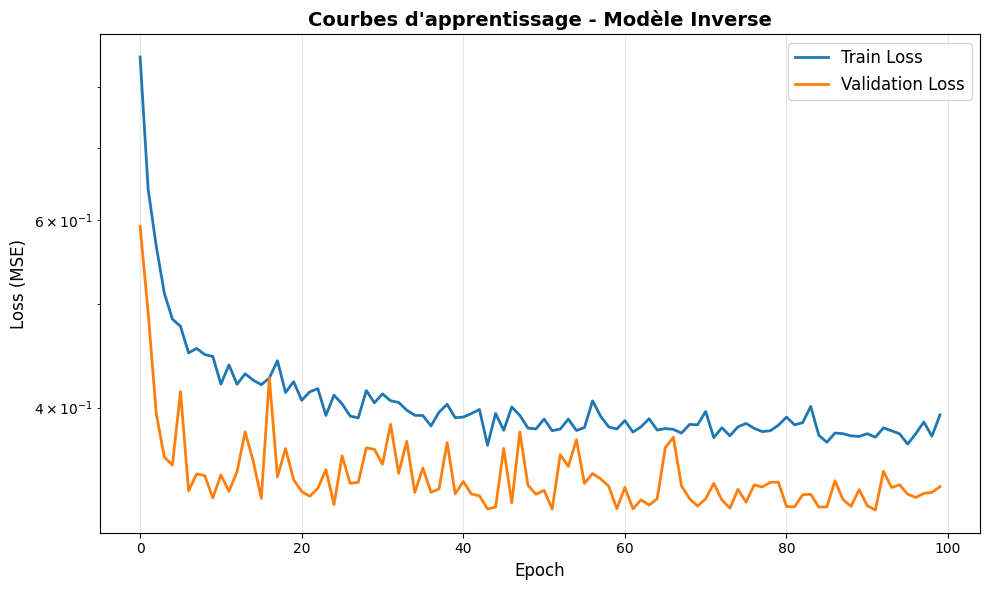

✓ Graphique sauvegardé : training_curves_inverse.png


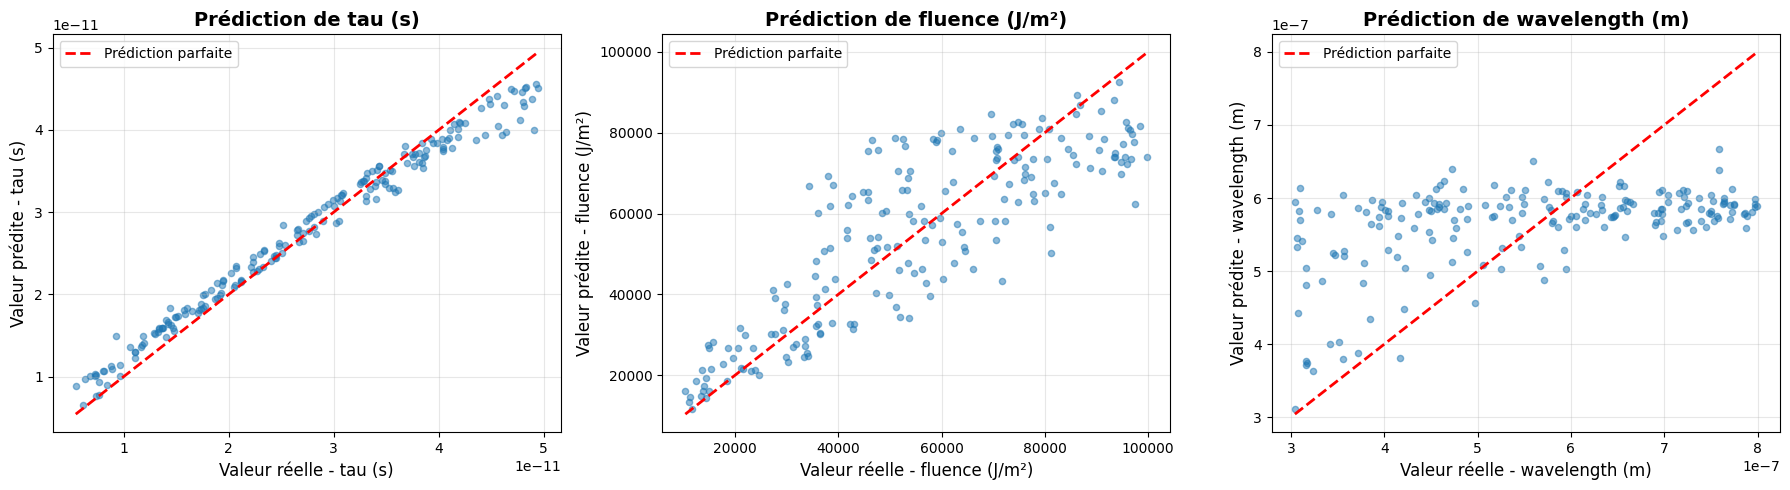


✓ Graphique sauvegardé : inverse_model_predictions.png


/tmp/ipython-input-3340522380.py:141: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 0].set_xticklabels(param_names, rotation=15, ha='right')


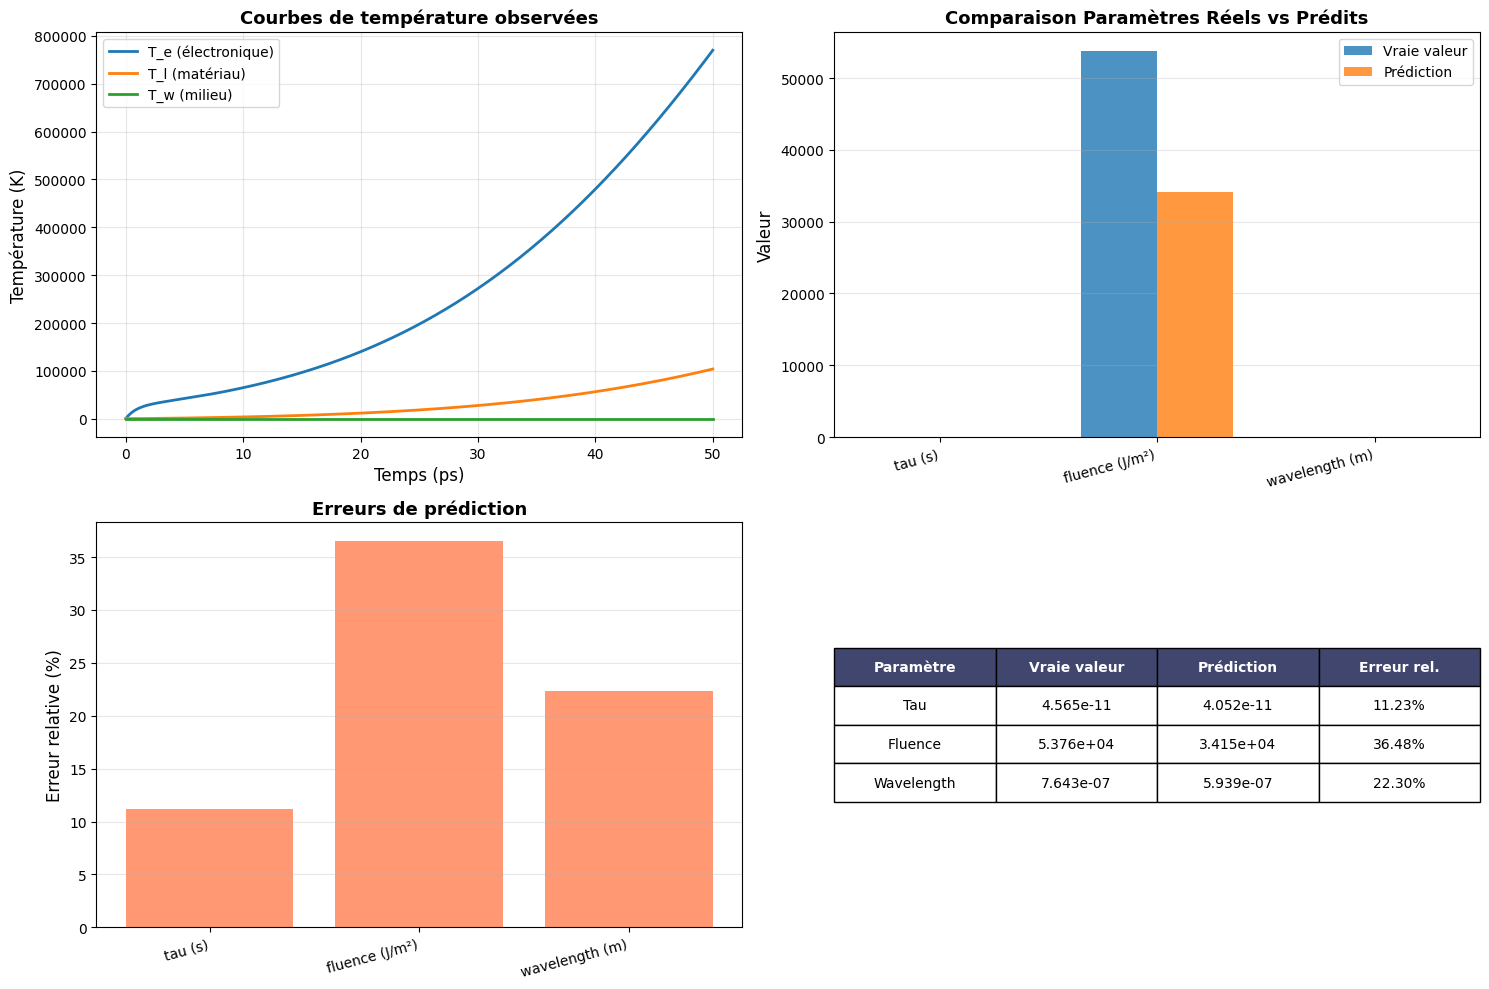


 Graphique sauvegardé : example_prediction_0.png


/tmp/ipython-input-3340522380.py:141: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 0].set_xticklabels(param_names, rotation=15, ha='right')


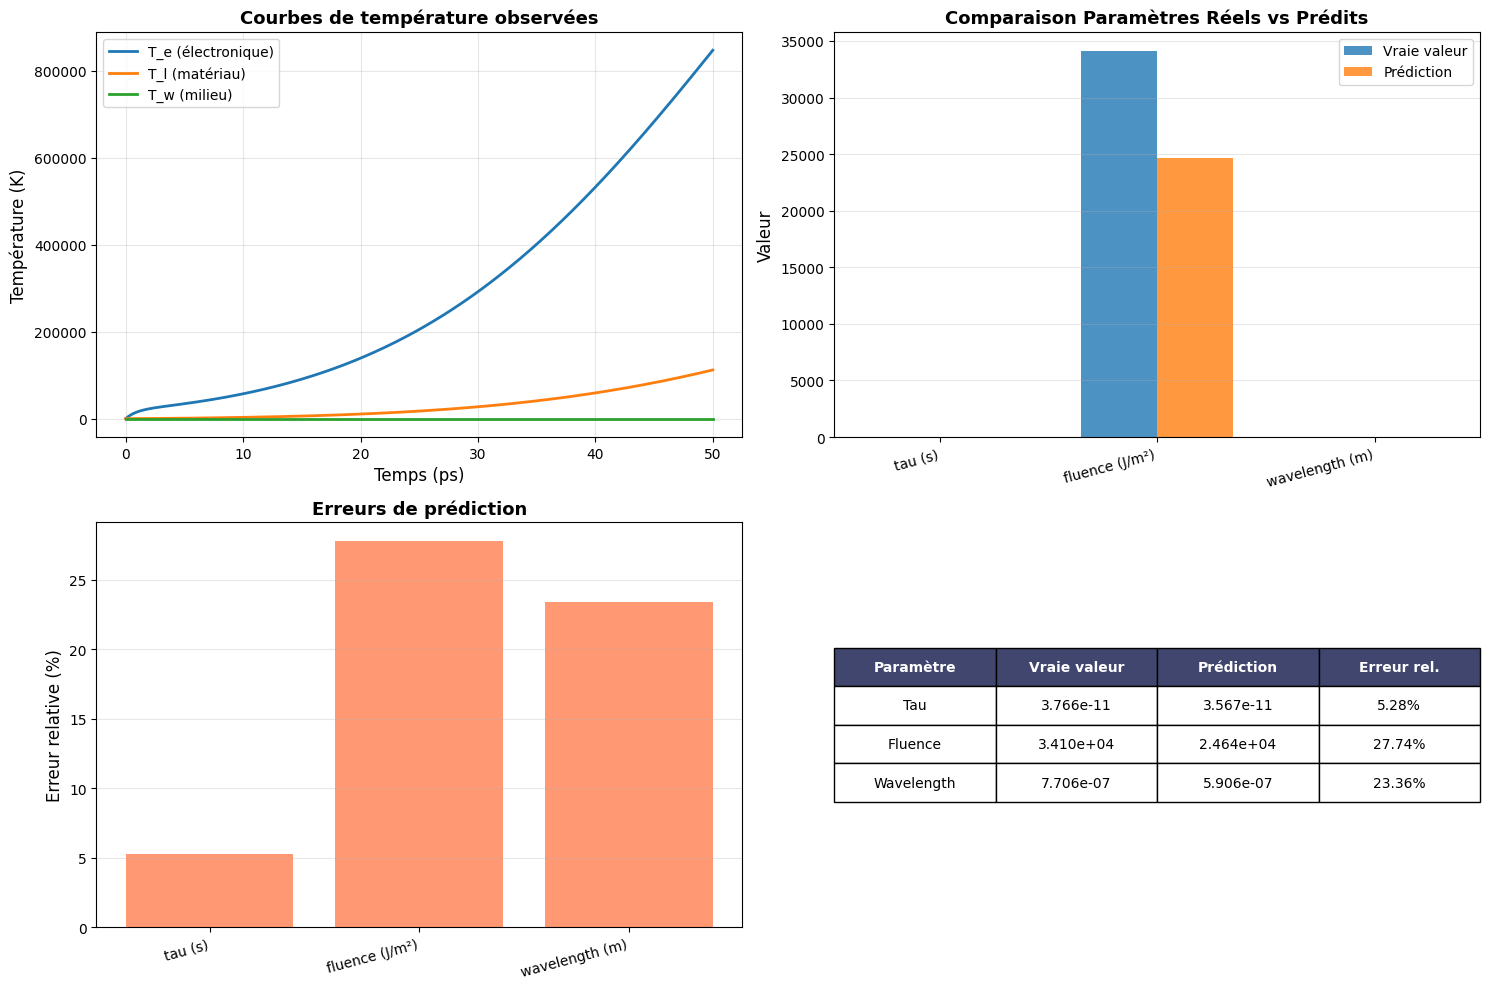


 Graphique sauvegardé : example_prediction_5.png

TÂCHE 3 TERMINÉE AVEC SUCCÈS

 Fichiers générés:
  - inverse_model_predictions.png
  - training_curves_inverse.png
  - example_prediction_0.png
  - example_prediction_5.png

 Suggestions d'amélioration:
  - Augmenter le nombre de simulations (N_SAMPLES)
  - Tester différentes architectures (CNN, LSTM)
  - Extraire des features physiques des courbes
  - Utiliser des techniques d'ensemble learning


In [36]:
if __name__ == "__main__":
    model, train_dataset, test_dataset, test_data = main()